In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
import wrangle_zillow as w
import explore as e
import scipy.stats as stats
from sklearn.linear_model import LinearRegression, LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error
plt.rc("font", size=13)
plt.rc("figure", figsize= (13,7))

## Acquire the data

In [2]:
df = w.get_zillow_data()

## Set up filters for properites
    - Propertylandusetypeid = [260,261,262,279]
    - Bedroomcnt > 0 and < 6
    - Bathroomcnt > 0 and < 5
    - Sqft < 7000
    - Unitcnt nulls == 1
    - Heatingorsystemdesc nulls replaced as “none”
    - Required columns and rows set at 60%. Anything below was dropped
    - Categorical variables with an acceptable amount of nulls missing replaced with the mode
    - Continuous variables with an acceptable amount of nulls missing replaced with the median

## Initial Thoughts
1. Is there a relationship between price_per_sqft and logerror?
2. Is there a relationship between bed_bath_ratio and logerror?
3. Is there a relationship between lot size per sqft and logerror?
4. Is there a relationship between lot size per sqft and price per sqft?

In [3]:
df= w.single_unit_properties(df)
df=w.handle_missing_values(df, prop_required_column = .60, prop_required_row = .60)
train, validate, test =w.impute_missing_values(df)
train, validate, test = w.impute_missing_values_1(train, validate, test)

## Quick visual of data

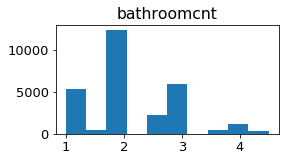

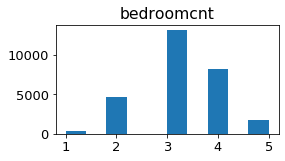

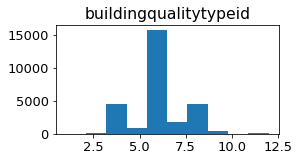

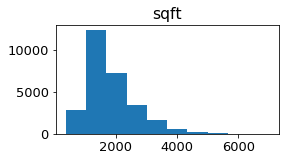

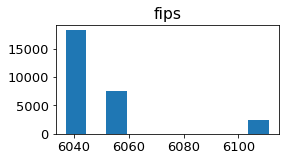

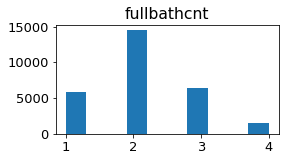

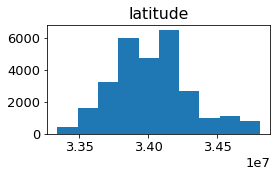

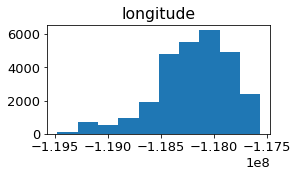

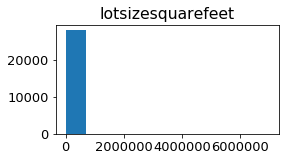

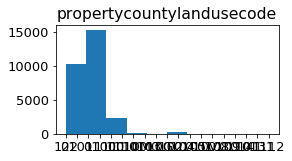

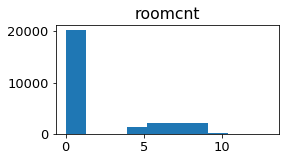

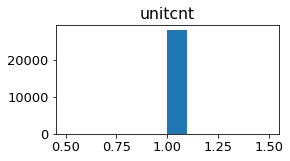

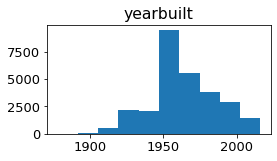

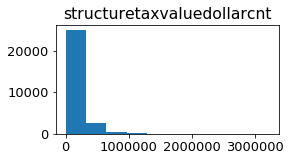

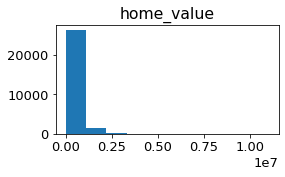

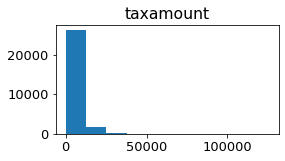

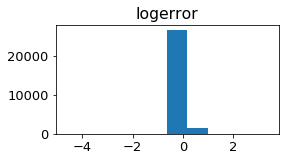

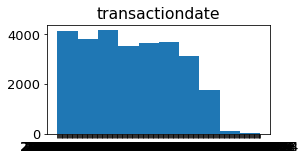

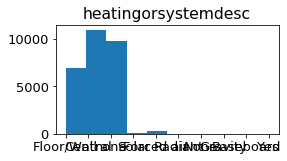

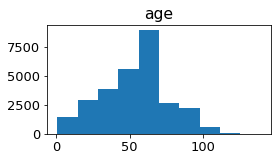

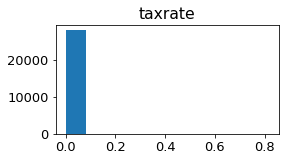

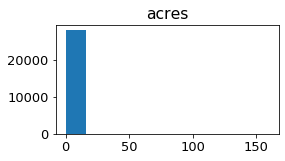

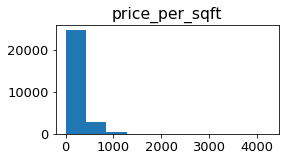

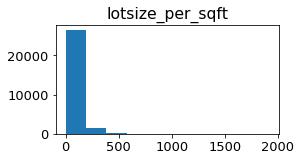

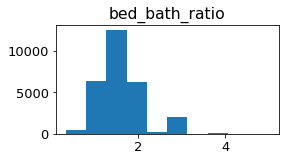

In [4]:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

## Features normally distributed
    - bedroomcnt
    - building quality type id
    - fullbathcnt
    - latitude
    - year built
    - age
    - bed bath ratio
    
## Features skewed right
    - sqft
    
## Features skewed left
    - longitude
    

## Is there a relationship between price_per_sqft and logerror?

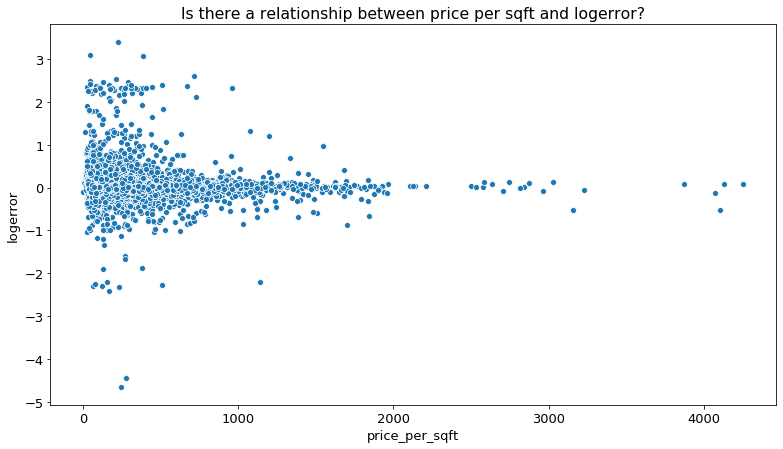

In [5]:
sns.scatterplot(data=train, x='price_per_sqft', y='logerror')
plt.title('Is there a relationship between price per sqft and logerror?')
plt.show()

## Creating bins of price per sqft (0 - 1000), (1000 - 2000) and (2000 - 5000)

In [6]:
train['binned_price_per_sqft'] = pd.cut(train.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])
validate['binned_price_per_sqft'] = pd.cut(validate.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])
test['binned_price_per_sqft'] = pd.cut(test.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])

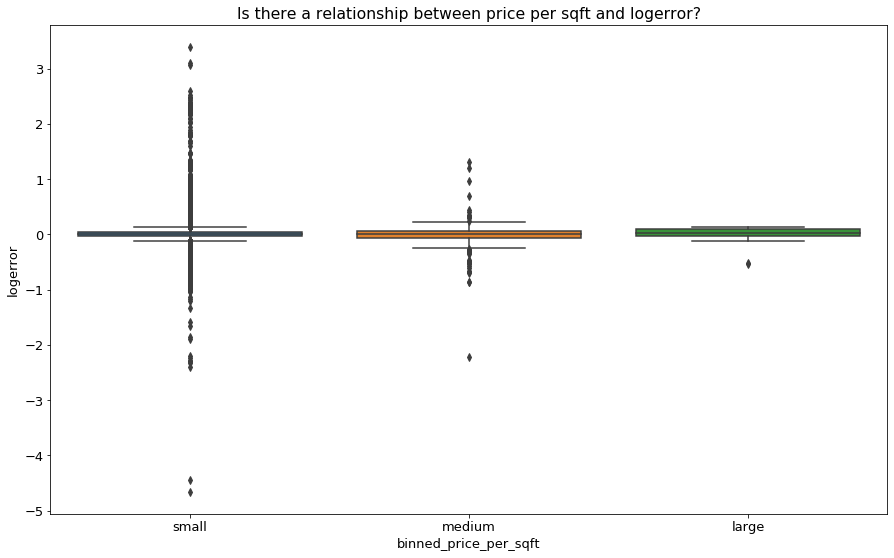

In [7]:
plt.figure(figsize=(15,9))
sns.boxplot(x= 'binned_price_per_sqft', y = 'logerror', data = train)
plt.title('Is there a relationship between price per sqft and logerror?')
plt.show()

## Hard to see if there is a correlation here. Going to run a statistical test (ANOVA) to see if there is a significance in the means of price per sqft and log error.

In [8]:
small_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'small'].price_per_sqft
medium_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'medium'].price_per_sqft
large_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'large'].price_per_sqft

- Ho: Means of binned price_per_sqft_ratio small, medium, large are equal
- Ha: Means of binned price_per_sqft_ratio small, medium, large are not equal
- alpha = .05

In [9]:
f, p = stats.f_oneway(small_price_per_sqft_ratio, medium_price_per_sqft_ratio, large_price_per_sqft_ratio)
f, p

(8553.03763805571, 0.0)

    - We reject the null Hypothesis. p-value is less than alpha. The means of binned price per sqft ratio are not equal.

## Is there a relationship between  bed_bath_ratio and logerror?

In [10]:
train['bed_bath_ratio'] = train["bed_bath_ratio"].round(2)

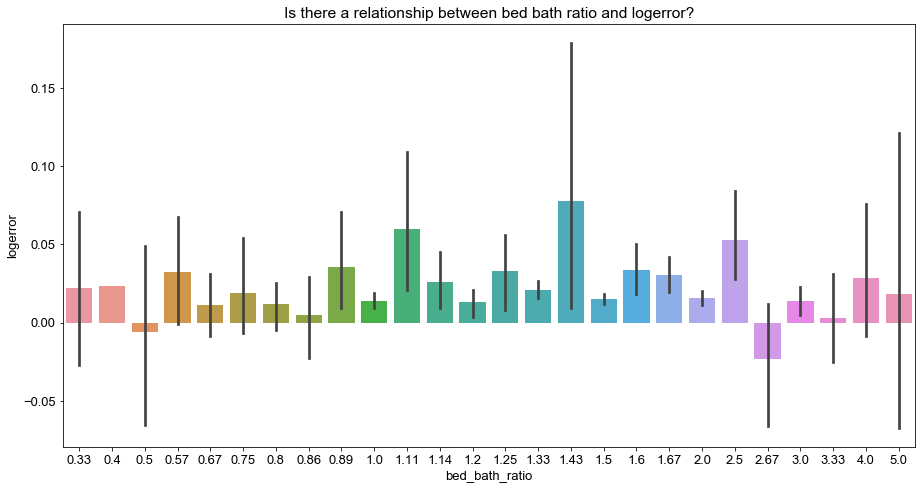

In [11]:
ax = sns.barplot(x= 'bed_bath_ratio', y = 'logerror', data = train)
plt.title('Is there a relationship between bed bath ratio and logerror?')
sns.set_style('ticks')
plt.tight_layout()

In [12]:
train['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])
validate['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])
test['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])

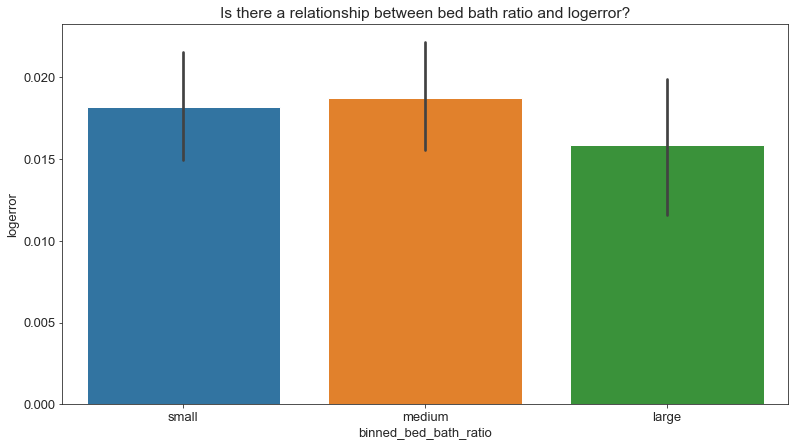

In [13]:
sns.barplot(x= 'binned_bed_bath_ratio', y = 'logerror', data = train)
plt.title('Is there a relationship between bed bath ratio and logerror?')
plt.show()

## Going to run a Annova Test to see if there is a significance in bed_bath_ratio to logerror

In [14]:
small_bed_bath_ratio = train[train.binned_bed_bath_ratio == 'small'].bed_bath_ratio
medium_bed_bath_ratio = train[train.binned_bed_bath_ratio == 'medium'].bed_bath_ratio
large_bed_bath_ratio = train[train.binned_bed_bath_ratio == 'large'].bed_bath_ratio

 - Ho: Means of binned bed_bath_ratio small, medium, large are equal
 - Ha: Means of binned bed_bath_ratio small, medium, large are not equal
 - alpha = .05

In [15]:
f, p = stats.f_oneway(small_bed_bath_ratio, medium_bed_bath_ratio, large_bed_bath_ratio)
f, p

(36557.235272644495, 0.0)

    - We reject the null Hypothesis. p-value is less than alpha. The means of binned price per sqft ratio are not equal.

## Heat map showing how the variables correlate to each other

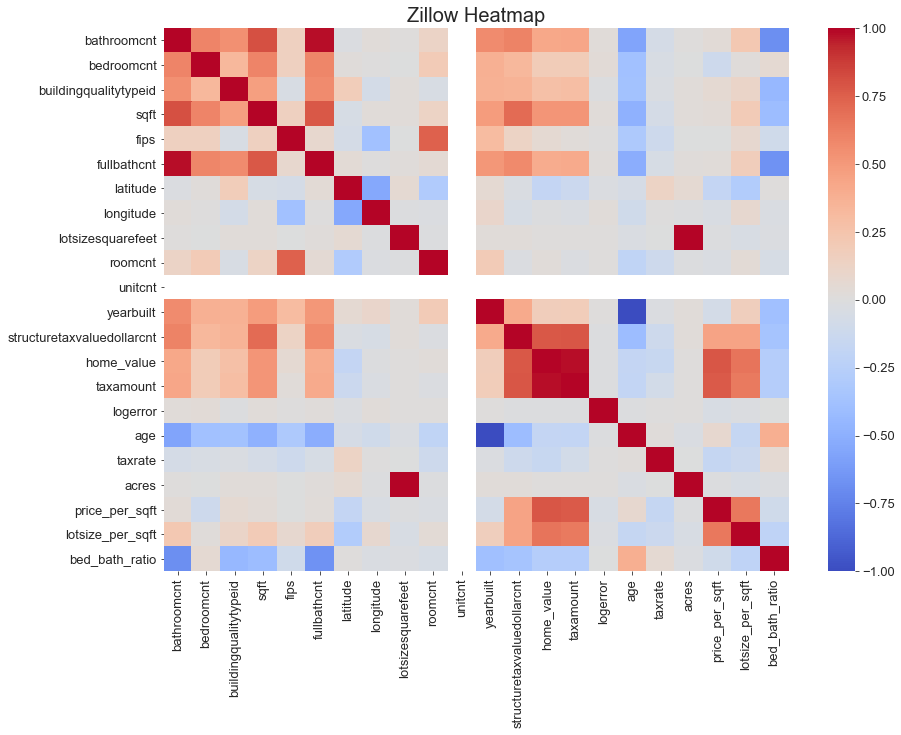

In [16]:
plt.figure(figsize=(14,10))
sns.heatmap(train.corr(),
            vmin = -1, 
            cmap='coolwarm',
           annot=False).set_title("Zillow Heatmap", fontsize=20);

## Is there a relationship between lot size per sqft and logerror?

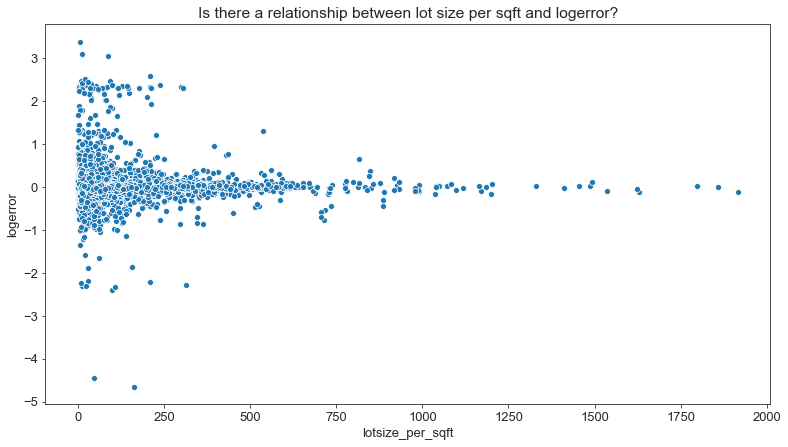

In [17]:
sns.scatterplot(data=train, x='lotsize_per_sqft', y='logerror')
plt.title('Is there a relationship between lot size per sqft and logerror?')
plt.show()

    - There appears to be a lot of error on the different lot sizes up to 300 or so before leveling off.

## Is there a relationship between lot size per sqft and price per sqft?

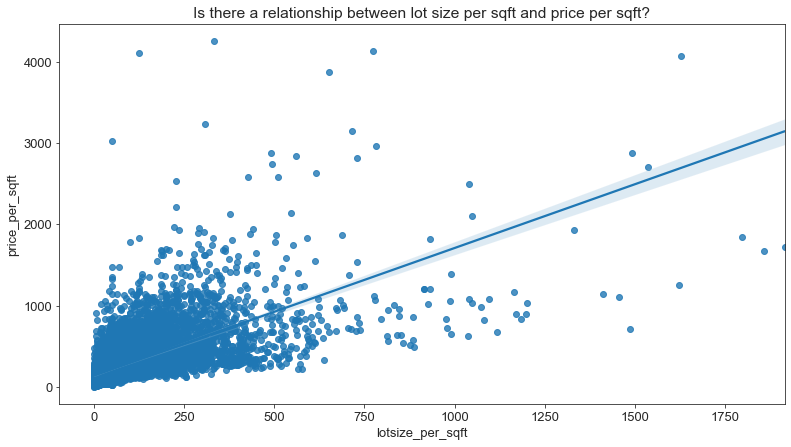

In [18]:
sns.regplot(data=train, x='lotsize_per_sqft', y='price_per_sqft')
plt.title('Is there a relationship between lot size per sqft and price per sqft?')
plt.show()

In [19]:
e.rfe_ranker(train)

,Feature,Rank
0,buildingqualitytypeid,1
6,roomcnt,1
7,yearbuilt,1
11,age,1
15,bed_bath_ratio,1
2,fips,2
13,price_per_sqft,3
1,sqft,4
14,lotsize_per_sqft,5
10,taxamount,6


### After editing my variables to rank I will look more into building quality type id, age, bed bath ratio, and price_per sqft

# Building quality type id and bed bath ratio clusters (n_clusters = 4)

In [20]:
 X_train, y_train, X_validate, y_validate, X_test, y_test = w.X_train_select(train, validate, test, target_var = 'logerror')

### Setting my scaler I want to use along with the variables I want to scale

In [21]:
scaler = StandardScaler()
columns_to_scale = train.drop(columns=["logerror",'propertycountylandusecode','transactiondate','heatingorsystemdesc','binned_price_per_sqft','binned_bed_bath_ratio']).columns.tolist()
X_train_scaled, X_validate_scaled, X_test_scaled = w.add_scaled_columns(X_train, X_validate, X_test, scaler, columns_to_scale)

     k           sse
0    2  27093.340755
1    3  11057.891242
2    4   8825.494550
3    5   6936.945036
4    6   5814.365782
5    7   3970.005225
6    8   3424.472883
7    9   2881.300040
8   10   2377.113356
9   11   1897.999224
10  12   1587.422741
11  13   1293.485303
12  14   1161.590401
13  15   1039.580810
14  16    886.160357
15  17    834.739848
16  18    717.244827
17  19    646.260640


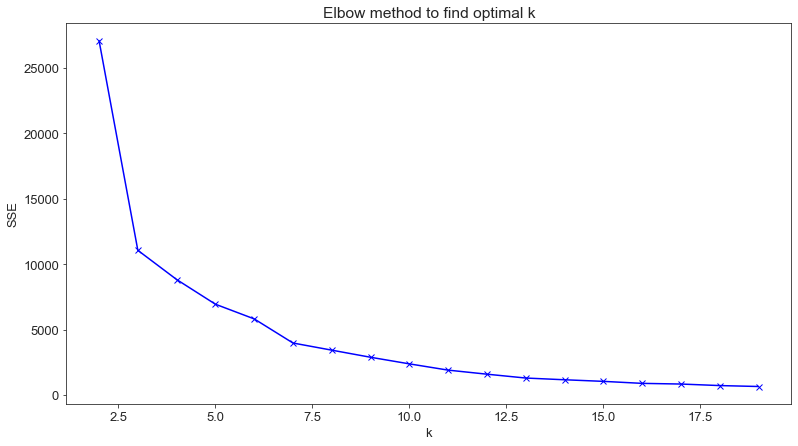

In [22]:
home_vars = ['buildingqualitytypeid', 'bed_bath_ratio']
e.elbow_plot(X_train_scaled, cluster_vars = home_vars)

##  k of 4 or 5 looks good. Going to use 4

In [23]:
train_clusters, kmeans = e.run_kmeans(X_train, X_train_scaled, k=4, 
                                    cluster_vars = ['buildingqualitytypeid', 'bed_bath_ratio'], 
                                    cluster_col_name = 'home_cluster')

In [24]:
centroid_col_names = ['centroid_' + i for i in home_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'home_cluster'})

In [25]:
# concatenate cluster id
X_train = pd.concat([X_train, train_clusters], axis=1)

#join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='home_cluster').\
                set_index(X_train.index)

In [26]:
# concatenate cluster id
X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                           axis=1)

# join on clusterid to get centroids
X_train_scaled = X_train_scaled.merge(centroids, how='left', on='home_cluster').\
                set_index(X_train.index)

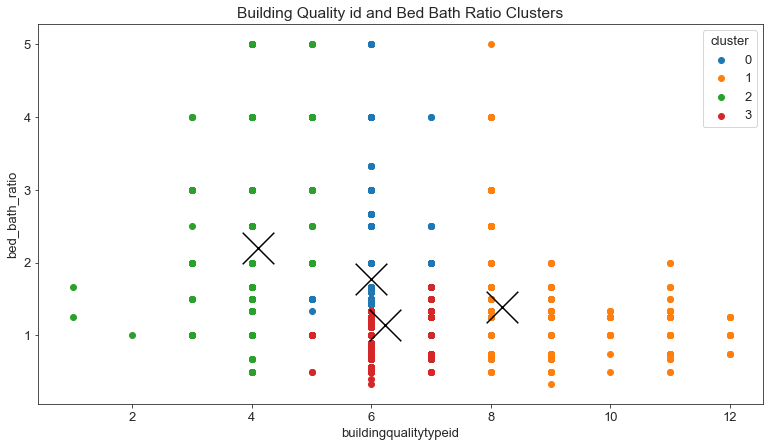

In [27]:
fig, ax = plt.subplots(figsize=(13, 7))
# for the column cluster, we can group by the cluster subset
for cluster, subset in X_train.groupby('home_cluster'):
    # Telling it to graph the cluster subset with the corresponding features
    ax.scatter(subset.buildingqualitytypeid, subset.bed_bath_ratio, label=cluster)
plt.title("Building Quality id and Bed Bath Ratio Clusters")
ax.legend(title='cluster')
ax.set(ylabel='Bed Bath Ratio', xlabel='Building Quality id')
# Making the X to lay on top of the scatter plot to see the mean() AKA centroid of each cluster
X_train.groupby('home_cluster').mean().plot.scatter(y='bed_bath_ratio', x='buildingqualitytypeid', marker='x', s=1000, ax=ax, c='black')

## Takeaways: No clear sign of distinct clusters. Going to move to the next test of clusters

# Price per sqft and age clusters (n_clusters = 5)

     k           sse
0    2  6.396525e+08
1    3  3.586461e+08
2    4  2.331257e+08
3    5  1.638895e+08
4    6  1.167755e+08
5    7  8.947993e+07
6    8  6.927729e+07
7    9  5.731131e+07
8   10  4.957327e+07
9   11  4.343870e+07
10  12  3.817912e+07
11  13  3.429584e+07
12  14  3.124291e+07
13  15  2.843942e+07
14  16  2.644517e+07
15  17  2.481795e+07
16  18  2.317175e+07
17  19  2.180597e+07


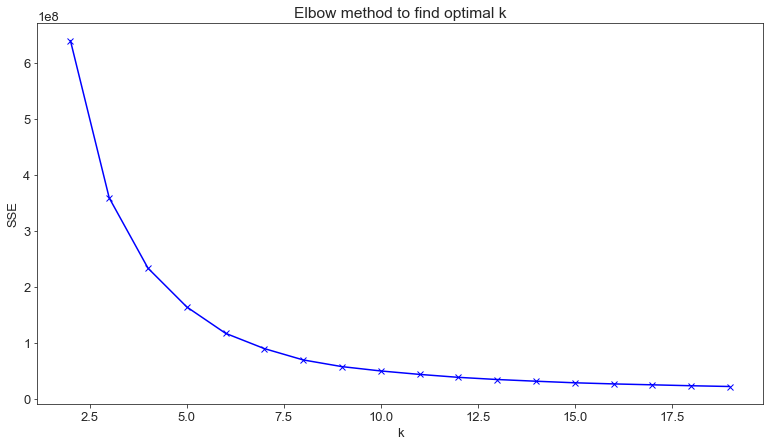

In [28]:
age_vars = ['price_per_sqft', 'age']
e.elbow_plot(X_train_scaled, cluster_vars = age_vars)

### k of 5 or 6 looks good. Going to use 5

In [29]:
train_clusters, kmeans = e.run_kmeans(X_train, X_train_scaled, k=5, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'age'], 
                                    cluster_col_name = 'age_cluster')

In [30]:
centroid_col_names = ['centroid_' + i for i in age_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'age_cluster'})

In [31]:
# concatenate cluster id
X_train = pd.concat([X_train, train_clusters], axis=1)


#join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='age_cluster').\
                set_index(X_train.index)


In [32]:
# concatenate cluster id
X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                           axis=1)

# join on clusterid to get centroids
X_train_scaled = X_train_scaled.merge(centroids, how='left', on='age_cluster').\
                set_index(X_train.index)

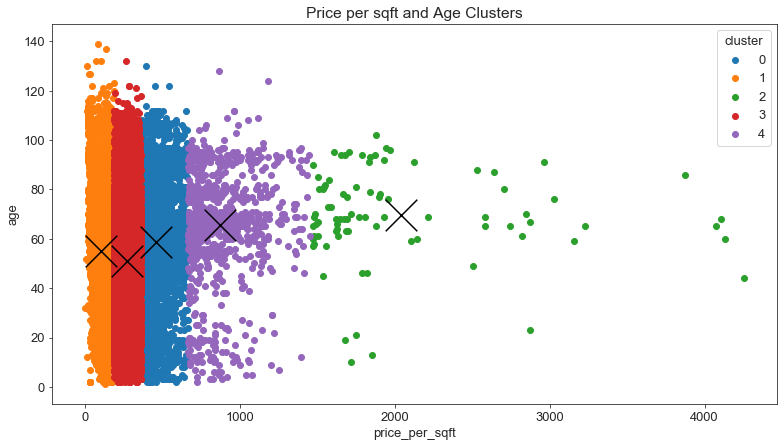

In [33]:
fig, ax = plt.subplots(figsize=(13, 7))
# for the column cluster, we can group by the cluster subset
for cluster, subset in X_train.groupby('age_cluster'):
    # Telling it to graph the cluster subset with the corresponding features
    ax.scatter(subset.price_per_sqft, subset.age, label=cluster)
plt.title("Price per sqft and Age Clusters")
ax.legend(title='cluster')
ax.set(ylabel='Age', xlabel='Price per sqft')
# Making the X to lay on top of the scatter plot to see the mean() AKA centroid of each cluster
X_train.groupby('age_cluster').mean().plot.scatter(y='age', x='price_per_sqft', marker='x', s=1000, ax=ax, c='black')

## Takeaways: Distinct vertical lines seperating clusters on price per sqft. There is a wide range in ages of homes for all clusters

## Price per sqft and lot size per sqft clusters (n_clusters = 4)

In [ ]:
size_vars = ['price_per_sqft', 'lotsize_per_sqft']
e.elbow_plot(X_train_scaled, cluster_vars = size_vars)

### k of 4 or 5 looks good. Going to use 4

In [ ]:
train_clusters, kmeans = e.run_kmeans(X_train, X_train_scaled, k=4, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'lotsize_per_sqft'], 
                                    cluster_col_name = 'size_cluster')
validate_clusters, kmeans = e.run_kmeans(X_validate, X_validate_scaled, k=4, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'lotsize_per_sqft'], 
                                    cluster_col_name = 'size_cluster')
test_clusters, kmeans = e.run_kmeans(X_test, X_test_scaled, k=4, 
                                    cluster_vars = ['price_per_sqft', 
                                                    'lotsize_per_sqft'], 
                                    cluster_col_name = 'size_cluster')

In [ ]:
centroid_col_names = ['centroid_' + i for i in size_vars]
centroid_col_names

centroids = pd.DataFrame(kmeans.cluster_centers_, 
             columns=centroid_col_names).reset_index().rename(columns={'index': 'size_cluster'})

In [ ]:
# concatenate cluster id
X_train = pd.concat([X_train, train_clusters], axis=1)
X_validate = pd.concat([X_validate, validate_clusters], axis=1)
X_test = pd.concat([X_test, test_clusters], axis=1)

#join on clusterid to get centroids
X_train = X_train.merge(centroids, how='left', on='size_cluster').\
                set_index(X_train.index)
X_validate = X_validate.merge(centroids, how='left', on='size_cluster').\
                set_index(X_validate.index)
X_test = X_test.merge(centroids, how='left', on='size_cluster').\
                set_index(X_test.index)

In [ ]:
# concatenate cluster id
X_train_scaled = pd.concat([X_train_scaled, train_clusters], 
                           axis=1)
X_validate_scaled = pd.concat([X_validate_scaled, validate_clusters], 
                           axis=1)
X_test_scaled = pd.concat([X_test_scaled, test_clusters], 
                           axis=1)

# join on clusterid to get centroids
X_train_scaled = X_train_scaled.merge(centroids, how='left', on='size_cluster').\
                set_index(X_train.index)
X_validate_scaled = X_validate_scaled.merge(centroids, how='left', on='size_cluster').\
                set_index(X_validate.index)
X_test_scaled = X_test_scaled.merge(centroids, how='left', on='size_cluster').\
                set_index(X_test.index)

In [ ]:
fig, ax = plt.subplots(figsize=(13, 7))
# for the column cluster, we can group by the cluster subset
for cluster, subset in X_train.groupby('size_cluster'):
    # Telling it to graph the cluster subset with the corresponding features
    ax.scatter(subset.price_per_sqft, subset.lotsize_per_sqft, label=cluster)
plt.title("Price per sqft and Lot Size per sqft Clusters")
ax.legend(title='cluster')
ax.set(ylabel='Lot size per sqft', xlabel='Price per sqft')
# Making the X to lay on top of the scatter plot to see the mean() AKA centroid of each cluster
X_train.groupby('size_cluster').mean().plot.scatter(y='lotsize_per_sqft', x='price_per_sqft', marker='x', s=1000, ax=ax, c='black')

In [ ]:
sns.boxplot(X_train.size_cluster, y_train.logerror)
plt.ylim(-.07,.07)
plt.show()

### Creating dummy variables for the size clusters

In [ ]:
dummy_df = pd.get_dummies(X_train_scaled,
                           columns=['size_cluster'], 
                           drop_first=True)
dummy_df1 = pd.get_dummies(X_validate_scaled,
                           columns=['size_cluster'], 
                           drop_first=True)
dummy_df2 = pd.get_dummies(X_test_scaled,
                           columns=['size_cluster'], 
                           drop_first=True)

In [ ]:
X_train_scaled = X_train_scaled.drop(columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio','home_cluster',
       'centroid_buildingqualitytypeid', 'centroid_bed_bath_ratio',
       'home_cluster', 'home_cluster', 'age_cluster',
       'centroid_price_per_sqft_x', 'centroid_age',
       'centroid_price_per_sqft_y', 'centroid_lotsize_per_sqft'])

In [ ]:
X_validate_scaled = X_validate_scaled.drop(columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio','centroid_price_per_sqft',
       'centroid_lotsize_per_sqft'])

In [ ]:
X_test_scaled = X_test_scaled.drop(columns = ['bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid', 'sqft', 'fips',
       'fullbathcnt', 'latitude', 'longitude', 'lotsizesquarefeet',
       'propertycountylandusecode', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'home_value', 'taxamount',
       'transactiondate', 'heatingorsystemdesc', 'age', 'taxrate',
       'acres', 'price_per_sqft', 'lotsize_per_sqft', 'bed_bath_ratio',
       'binned_price_per_sqft', 'binned_bed_bath_ratio','centroid_price_per_sqft',
       'centroid_lotsize_per_sqft'])

## Creating a baseline

In [ ]:
sns.distplot(y_train, axlabel = 'Logerror')
plt.xlim(-.6,.6)
plt.ylim(0, 7)
plt.title("Distribution of Dependent Variable (logerror)")
plt.show()

In [ ]:
mean = np.mean(y_train)
print(mean)

In [ ]:
y_train.shape

In [ ]:
baseline_rmse = mean_squared_error(y_train, np.full(28133, np.mean(y_train)))**(1/2)
print (f'Baseline RMSE is {baseline_rmse}')

# Linear Regression Model

In [ ]:
# Initiate model
lm = LinearRegression()
# Fit the model
lm.fit(X_train_scaled, y_train)
# Make predictions
lm_pred = lm.predict(X_train_scaled)
# Compute RMSE
lm_rmse = mean_squared_error(y_train, lm_pred)**(1/2)
print(f' Linear Regression Train model RMSE is {lm_rmse}')

# Lassolars Model

In [ ]:
# Initiate model
lars = LassoLars(alpha=1)
# Fit the model
lars.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred = lars.predict(X_train_scaled)
# Compute RMSE
lars_rmse = mean_squared_error(y_train, lars_pred)**(1/2)
print(f' Lassolars Train model RMSE is {lars_rmse}')

In [ ]:
# Initiate model alpha set to 20
lars2 = LassoLars(alpha=20)
# Fit the model
lars2.fit(X_train_scaled, y_train)
# Make Predictions
lars_pred2 = lars2.predict(X_train_scaled)
# Compute RMSE
lars_rmse2 = mean_squared_error(y_train, lars_pred2)**(1/2)
print(f' Lassolars Train model RMSE is {lars_rmse2}')

# Polynomial Features Model

In [ ]:
# Initiate model
pf = PolynomialFeatures(degree=2)

# Fit and transform the model to get new features (originals squared)
X_train_squared = pf.fit_transform(X_train_scaled)
X_validate_squared = pf.transform(X_validate_scaled)  
X_test_squared = pf.transform(X_test_scaled)          

# New features inputed into linear model. 
lm_squared = LinearRegression(normalize=True)
lm_squared.fit(X_train_squared, y_train)
# Make predictions
lm_squared_pred = lm_squared.predict(X_train_squared)
# Compute RMSE
lm_squared_rmse = mean_squared_error(y_train, lm_squared_pred)**(1/2)
print(f' Polynomial Features model RMSE is {lm_squared_rmse}')

### Take aways:
    - Polynomial performed the best with a RMSE of 0.17220
    - Linear Regression model was the 2nd best with a RMSE of 0.17330
    - Both Lassolars models performed the same with an RMSE of 0.17374
    - Going to validate on the 3 top models including the first Lassolars

# Validate Linear Regression Model

In [ ]:
# Make predictions
lm_pred_v = lm.predict(X_validate_scaled)
# Compute RMSE
lm_rmse_v = mean_squared_error(y_validate, lm_pred_v)**(1/2)
print(f' Linear Regression validate model RMSE is {lm_rmse_v}')

# Validate Lassolars Model

In [ ]:
# Make predictions
lars_pred_v = lars.predict(X_validate_scaled)
# Compute RMSE
lars_rmse_v = mean_squared_error(y_validate, lars_pred_v)**(1/2)
print(f' Lassolars validate model RMSE is {lars_rmse_v}')

# Validate Polynomial Features Model

In [ ]:
# Make predictions
lm_squared_pred_v = lm_squared.predict(X_validate_squared)
# Compute RMSE
lm_squared_rmse_v = mean_squared_error(y_validate, lm_squared_pred_v)**(1/2)
print(f' Polynomial validate model RMSE is {lm_squared_rmse_v}')

### Takeaways:
    - Lassolars and Linear Regression models did great on the validate stage. 
    - Lassolars RMSE = 0.16411 beat the Linear Regression RMSE = 0.16436
    - Testing the Lassolars model

# Testing the Lasolars Model 

In [ ]:
# Make predictions
lars_pred_t = lars.predict(X_test_scaled)
# Compute RMSE
lars_rmse_t = mean_squared_error(y_test, lars_pred_t)**(1/2)
print(f' Lassolars test model RMSE is {lars_rmse_t}')

# Conclusions
- ANNOVA tests were ran on price per square feet and logerror & bed bath ratio and logerror
- Means were differnent in both test so the Ho was rejected
- Clusters were created comparing building quality type id & bed bath ratio, price per sqft & age, and price per sqft and lot size per sqft
- Dummy variables were created with clusters of price per sqft and lot size per sqft
- Modeling was performed with scaled data along with the cluster dummies
- The best model (Lassolars) did out perform the baseline RMSE 0.17374 on train and validate but did not on test 0.18188
- Further testing needs to be done to see how different features can help reduce the RMSE of logerror
- Look further into the relationship of binned bed bath ratio and logerror
- Create dummy variables with price per sqft and age to model